# 競馬予測_スクレイピング

### 0. colabの環境を整える

#### 0-1. git clone

In [ ]:
!git clone https://github.com/yuugo0724/keiba_prediction.git

#### 0-2. 作業ブランチの作成

In [ ]:
# cloneしたディレクトリに移動
%cd ./keiba_prediction

# ブランチ名がmainであること
!git branch
# 作業ブランチの作成
!git branch [作業ブランチ名]
# 作業ブランチにチェックアウト
!git checkout [作業ブランチ名]
# 作業ブランチにチェックアウトできていることを確認
!git branch

#### 0-2. ソースコードのディレクトリに移動

In [ ]:
%cd src/

#### 0-3. pythonのライブラリをインストール

In [ ]:
pip install -r ../dockerfile/requirements.txt

### 1. importと変数の定義

#### 1-1. import

In [1]:
"""
ライブラリ
"""
import pandas as pd
"""
モジュール(定数)
"""
# ローカルパス
from modules.constants import LocalPaths
# 学習データのパス
from modules.constants import TrainDataPaths
# データフレームの列名
from modules.constants import DataFrameCols
# レース名のマスター
from modules.constants import RaceInfo
"""
モジュール(前処理)
"""
# データフレームの作成
from modules.preprocess import create_dataframe
# スクレイピング
from modules.preprocess import scrapy_proc
# データフレームの整形
from modules.preprocess import dataframe_grades
"""
モジュール(モデルの学習)
"""
from modules.training import data_training

/home/keiba/.local/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### 1-2. インスタンスの初期化

In [2]:
lps = LocalPaths()
df_cols = DataFrameCols()
race_info = RaceInfo()
# スクレイピング用クラスのインスタンス化
scrapy_proc = scrapy_proc(lps)
# マスタ作成用クラスのインスタンス化
create_dataframe = create_dataframe(lps, df_cols)
# 学習データのパスクラスをインスタンス化
#   モデルのタイプ
#     multiclass_3
#     multiclass_5
#     binaryclass ※上手く動かせない・・・
#   カテゴリ変数の処理方法を決める
#     ラベルエンコーディング　：label
#     ダミー変数化　　　　　　：dummies ※列が多くなりすぎるため廃止
#     カウントエンコーディング：count  ※競馬予測に向いていない
tdp = TrainDataPaths('multiclass_5','label')

### 2. スクレイピング
1. スクレイピング対象のurlを取得  
2. レース結果データを取得  
3. 馬ごとの成績データを取得  
  ※学習データとしては、まだ利用していない  
4. 血統データを取得  
  ※学習データとしては、まだ利用していない  

#### 2-1. スクレイピング対象のurl取得

In [ ]:
# urlを取得する日付のレンジを指定
df_gen_date = pd.date_range(start="20221201",end="20221231", freq="MS")
# フォーマットを変えてリストに格納
df_date = df_gen_date.to_series().dt.strftime("%Y%m")
race_date_list = df_date.values

# スクレイピング対象のurlをスクレイピング
scrapy_proc.coll_urls(race_date_list)

#### 2-2. レース結果のパスリスト作成

In [ ]:
# urlファイルのパスリストを定義
scrapy_proc.create_path_list()

#### 2-3. レース結果の取得

In [ ]:
# レース結果を取得する日付のレンジを指定
df_gen_date = pd.date_range(start="20221201",end="20221231", freq="MS")
# フォーマットを変えてリストに格納
df_date = df_gen_date.to_series().dt.strftime("%Y%m")
race_date_list = df_date.values

# レース結果対象のurlパスリスト作成
scrapy_proc.create_race_path_list(race_date_list)
# レース結果のスクレイピング
scrapy_proc.coll_grades()

#### 2-4. レース結果マスターの作成

In [3]:
# レース結果を取得する日付のレンジを指定
df_gen_date = pd.date_range(start="20140101",end="20221231", freq="MS")
# フォーマットを変えてリストに格納
df_date = df_gen_date.to_series().dt.strftime("%Y%m")
race_date_list = df_date.values

create_dataframe.create_master_grades(race_date_list)

#### 2-6. レース結果マスターの読み込み

In [4]:
grades_master = pd.read_pickle(lps.DATA_GRADES_MASTER, compression='zip')

#### 2-7. 馬IDマスターの作成
※現状学習データに含めるつもりはないので実施不要  
　今後、学習データに含める場合にコードを修正

In [5]:
create_dataframe.create_master_horseid(grades_master)

#### 2-8. 騎手IDマスターの作成

In [6]:
create_dataframe.create_master_jockeyid(grades_master)

#### 2-9. 調教師IDマスターの作成

In [7]:
create_dataframe.create_master_trainerid(grades_master)

#### 【未実装】2-10. 馬ごとのレース結果を取得
※現状学習データに含めるつもりはないので実施不要  
　今後、学習データに含める場合にコードを修正

In [ ]:
horse_id_list = ["2018104963","2018105074"]
#horse_id_list = df_horse_id_master.values

scrapy_proc.coll_horse_grades(horse_id_list)

#### 【未実装】2-11. 血統データを取得
※現状学習データに含めるつもりはないので実施不要  
　今後、学習データに含める場合にコードを修正

In [ ]:
horse_id_list = ["2018104963","2018105074"]
#horse_id_list = df_horse_id_master.values

scrapy_proc.coll_predigree(horse_id_list)

### 3. 前処理

#### 3-1. 前処理に必要なクラスのインスタンス化

In [8]:
# レース結果マスタを読み込み
grades_master = pd.read_pickle(lps.DATA_GRADES_MASTER, compression='zip')
# データフレームの処理クラスのインスタンス化
grades = dataframe_grades(grades_master, lps, tdp, df_cols, race_info)

#### 3-2. レース情報を分割し、下記列を追加
- 距離
- 回り
- タイプ
- 馬場状態

In [9]:
grades.train_split_raceinfo()

#### ~~【不要】 G1・G2・G3レースに絞る~~
学習データが減りすぎるため不採用

In [ ]:
#grades.select_G_race()

#### 3-3. レース結果マスタのデータ整形

In [10]:
# 競馬場名を指定
# 例：中山
place_name = None
#place_name = '中山'

# 欠損値の削除
grades.remove_missing_values()
# 体重増減の記号(+)を削除
grades.conversion_values()
# 性齢を性と齢で分割
grades.split_sexual_age()
# 競馬場指定(デフォルト指定なし)
grades.select_place_name(place_name)
# レースタイプを指定(デフォルト指定なし)
# 芝・ダート・障
# 引数はリスト
race_type_list = ['芝','ダート']
grades.select_race_type(race_type_list)
# スクレイピングの不具合で周りに「障」が含まれているため、その削除
#grades.tmp_del_shougai()
# 整数型に型変換
grades.conversion_int()

/home/keiba/src/modules/preprocess/_dataframe_shaping.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.grades_master[self.df_cols.WEIGHT_INC_DEC] = conv_weight_inc_dec_list
/home/keiba/src/modules/preprocess/_dataframe_shaping.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.grades_master[self.df_cols.SEX] = sex
/home/keiba/src/modules/preprocess/_dataframe_shaping.py:121: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexe

#### 3-4. レース結果マスタから目的変数用に着順を変更
モデルのタイプ  
- multiclass_3  
  １着　：0  
  ２着　：1  
  ３着　：2  
  その他：3  
- multiclass_5  
  １着　：0  
  ２着　：1  
  ３着　：2  
  ４着　：3  
  ５着　：4  
  その他：5  
- binaryclass ※上手く動かせない・・・  
  １着　：0  
  その他：1  

In [11]:
grades.train_data_model_type()

#### 3-5. カテゴリ変数(馬名・騎手・調教師)の処理
共通で処理するカテゴリ変数  
- 回り
- タイプ
- 性

In [12]:
grades.category_process()

#### 3-6. 学習データの前処理・保存
【前処理】  
1. アンダーサンプリング  
2. ~~標準化~~  
  ※決定木では不要なため実施しない  

【保存】  
- 説明変数  
- 目的変数  
- 学習データ  
- 検証データ  
- LightGBMのデータセット  

In [13]:
grades.data_preprocess()

### 4. モデルの学習

#### 4-1. クラスのインスタンス化

In [14]:
data_train = data_training(lps, tdp, df_cols)

#### 4-2. モデルの学習

In [ ]:
data_train.train_lgb()

#### 4-3. モデルのパラメータを確認

In [15]:
# パラメータをロード
data_train.load_parameter()

In [16]:
# パラメータを確認
data_train.show_parameter()

                                  0
task                          train
boosting_type                  gbdt
objective                multiclass
num_class                         6
metric                multi_logloss
feature_pre_filter            False
lambda_l1                  7.639527
lambda_l2                  0.165218
num_leaves                       32
feature_fraction              0.416
bagging_fraction                1.0
bagging_freq                      0
min_child_samples                20
num_iterations                 1000
early_stopping_round             10


In [17]:
# 混合配列を確認
data_train.show_mixed_array()

正解率(accuracy_score):0.27801254962223076
再現率(recall_score):0.2780123634779272
適合率(precision_score):0.2738244372147052
F1値(f1_score):0.2608156711720397
|            |   pred_1着 |   pred_2着 |   pred_3着 |   pred_4着 |   pred_5着 |   pred_その他 |
|:-----------|-----------:|-----------:|-----------:|-----------:|-----------:|--------------:|
| act_1着    |       4345 |       1015 |        697 |        758 |        797 |          1462 |
| act_2着    |       2997 |       1745 |        716 |        857 |       1044 |          1730 |
| act_3着    |       2544 |       1025 |       1331 |        919 |       1090 |          2222 |
| act_4着    |       2306 |        981 |        764 |       1480 |       1112 |          2456 |
| act_5着    |       1944 |        978 |        740 |        868 |       1871 |          2721 |
| act_その他 |       1466 |        689 |        639 |        796 |       1133 |          4425 |


In [18]:
# 分類レポートを確認
data_train.show_report()

              precision    recall  f1-score   support

          1着       0.28      0.48      0.35      9074
          2着       0.27      0.19      0.22      9089
          3着       0.27      0.15      0.19      9131
          4着       0.26      0.16      0.20      9099
          5着       0.27      0.21      0.23      9122
         その他       0.29      0.48      0.37      9148

    accuracy                           0.28     54663
   macro avg       0.27      0.28      0.26     54663
weighted avg       0.27      0.28      0.26     54663



#### 4-4. 学習推移を確認

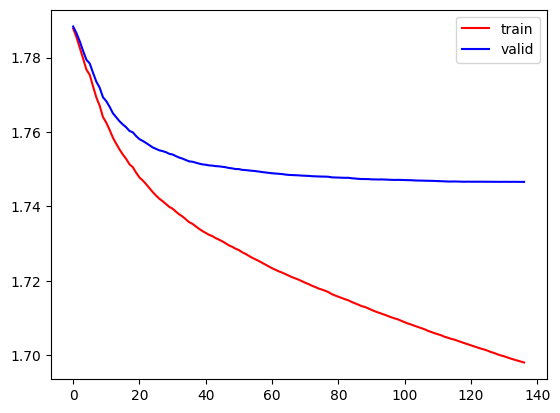

In [19]:
data_train.show_graph()

In [20]:
# 頻度とゲインを表示
# 引数
#  頻度：'split'
#  ゲイン：'gain'
data_train.show_feature_importance('split')

             importance
調教師ID_LABEL        5527
騎手ID_LABEL         5437
馬ID_LABEL          5362
馬体重                4534
馬体重増減              3263
距離                 2787
斥量                 2393
枠番                 2287
齢                  1792
回り_右                233
回り_左                229
タイプ_ダート             227
性_牝                 205
性_牡                 205
性_セ                 103
タイプ_芝                97
回り_                  94


In [21]:
# 頻度とゲインを表示
# 引数
#  頻度：'split'
#  ゲイン：'gain'
data_train.show_feature_importance('gain')

               importance
騎手ID_LABEL   32082.064453
馬ID_LABEL    29068.491126
調教師ID_LABEL  14400.038810
馬体重          11878.278802
齢             7121.520241
馬体重増減         6150.724345
距離            6012.715430
斥量            5921.569572
枠番            4135.620593
性_牝            822.149450
性_牡            561.076414
タイプ_ダート        506.273264
回り_右           445.451576
回り_左           387.274821
回り_            329.687633
タイプ_芝          226.327437
性_セ            211.804578


### 5. 予測

#### 5-1. 予測クラスのインスタンス化

In [22]:
# 学習データのパスクラスをインスタンス化
#   モデルのタイプ
#     multiclass_3
#     multiclass_5
#     binaryclass
#   カテゴリ変数の処理方法を決める
#     ラベルエンコーディング　：pred_label
#     ダミー変数化　　　　　　：pred_dummies
#     カウントエンコーディング：pred_count
pred_tdp = TrainDataPaths('multiclass_5','pred_label')

#### 5-2. 予測するレースurlをセット
既に着順が出ているレースはエラーになる

In [ ]:
pred_url = 'https://race.netkeiba.com/race/shutuba.html?race_id=202206050811&rf=race_list'

#### 5-3. 予測レースのスクレイピング

In [ ]:
scrapy_proc.coll_pred_grades(pred_url)

#### 5-4. 前処理に必要なクラスのインスタンス化

In [23]:
# レース結果マスタを読み込み
pred_keiba = pd.read_pickle(lps.DATA_TMP_PRED)
# データフレームの処理クラスのインスタンス化
predict = dataframe_grades(pred_keiba, lps, pred_tdp, df_cols, race_info)

#### 5-5. レース情報を分割し、下記列を追加
- 距離
- 回り
- タイプ
- 馬場状態

In [24]:
predict.pred_split_raceinfo()

#### 5-6. 予測レース結果を整形

In [25]:
# 競馬場名を指定
# 例：中山
place_name = None

# 体重増減の記号(+)を削除
predict.pred_conversion_values()
# 性齢を性と齢で分割
predict.split_sexual_age()
# 競馬場指定(デフォルト指定なし)
predict.select_place_name(place_name)
# レースタイプを指定(デフォルト指定なし)
# 芝・ダート・障
# 引数はリスト
race_type_list = ['芝','ダート']
predict.select_race_type(race_type_list)
# 空白列を0で埋める
predict.blank_conversion()
#grades.tmp_del_shougai()
# 整数型に型変換
predict.pred_conversion_int()

#### 5-7. カテゴリ変数(馬名・騎手・調教師)の処理
共通で処理するカテゴリ変数  
- 回り
- タイプ
- 性

In [26]:
predict.category_process()

#### 5-8. 学習データのダミー変数化した列をマージ

In [27]:
predict.pred_merge_dummies()

#### 5-9. 予測データに空白列が含まれることがあるので削除

In [28]:
predict.blank_conversion()

#### 5-10. 予測データを読み込み

In [29]:
pred_data = predict.grades_master

### 【確認用】予測データのデータ型を確認

In [ ]:
predict.show_grades_master()

#### 【確認用】予測データをcsv出力

In [ ]:
predict.grades_master.to_csv('/home/keiba/src/data/tmp/pred_race_grades.csv')

#### 5-11. モデル用クラスをインスタンス化

In [30]:
data_pred = data_training(lps, pred_tdp, df_cols)

#### 5-12. 予測結果を表示・json出力

In [31]:
data_pred.model_predict_detail(pred_data)

                 1着        2着        3着        4着        5着       その他
アカイイト      0.174368  0.171681  0.148168  0.205522  0.175565  0.124695
イズジョーノキセキ  0.182466  0.175309  0.227987  0.145998  0.190586  0.077654
ボルドグフーシュ   0.270771  0.225822  0.189437  0.151230  0.125341  0.037399
アリストテレス    0.200753  0.196165  0.186654  0.172461  0.165725  0.078241
ジェラルディーナ   0.274812  0.189154  0.175488  0.154312  0.138375  0.067860
ヴェラアズール    0.193936  0.228516  0.207213  0.145880  0.153493  0.070962
エフフォーリア    0.207803  0.174681  0.228269  0.174366  0.126097  0.088784
ウインマイティー   0.155973  0.195849  0.203559  0.148956  0.178756  0.116907
イクイノックス    0.420085  0.225839  0.139012  0.098691  0.093557  0.022816
ジャスティンパレス  0.203915  0.167029  0.220869  0.155079  0.161559  0.091549
ラストドラフト    0.113047  0.169610  0.155236  0.180310  0.257328  0.124469
ポタジェ       0.170087  0.202525  0.196733  0.170565  0.181122  0.078968
タイトルホルダー   0.215751  0.175884  0.166481  0.168727  0.177420  0.095736
ボッケリーニ     0.143840 